# Do some imports

In [1]:
from typing import List
import numpy as np
import pandas as pd
#!pip install --user pandas

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

from dataloader import UNSW_NB15

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option("display.precision", 30)

### Inspired by [this github file](https://github.com/alik604/cyber-security/blob/master/Intrusion-Detection/UNSW_NB15%20-%20Torch%20MLP%20and%20autoEncoder.ipynb)

# Get UNSW_NB15 train and test set

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_training-set.csv

In [ ]:
#!wget https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/a%20part%20of%20training%20and%20testing%20set/UNSW_NB15_testing-set.csv

# Define the Neural Network class

In [ ]:
# define NN architecture
class Net(nn.Module):
    
    def __init__(self, input_size,hidden1, hidden2, hidden3, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1)
        self.batchnorm1 = nn.BatchNorm1d(hidden1)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.batchnorm2 = nn.BatchNorm1d(hidden2)
        self.relu2 = nn.ReLU()

        
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.batchnorm3 = nn.BatchNorm1d(hidden3)
        self.relu3 = nn.ReLU()

        
        self.out = nn.Linear(hidden3, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        a1 = self.fc1(x)
        #b1 = self.batchnorm1(a1)
        h1 = self.relu1(a1)
        dout1 = self.dout(h1)
        
        a2 = self.fc2(dout1)
        #b2 = self.batchnorm2(a2)
        h2 = self.relu2(a2)
        dout2 = self.dout(h2)
        
        a3 = self.fc3(dout2)
        #b3 = self.batchnorm3(a3)
        h3 = self.relu3(a3)
        dout3 = self.dout(h3)
        
        a4= self.out(dout3)
        y = self.sigmoid(a4)
        return y

### Define Train,   Test   and    Display_Loss_Plot    methods

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    losses = []
    model.train()
    y_true = []
    y_pred = []
    
    for i, data in enumerate(train_loader, 0):
        
        # get the inputs; data is a list of [inputs, target ( or labels)]
        inputs , target = data
        
        optimizer.zero_grad()
        
        #MOVING THE TENSORS TO THE CONFIGURED DEVICE
        #inputs, target = inputs.to(device), target.to(device)
        
        #FORWARD PASS
        output = model(inputs.float())

        loss = criterion(output, target.unsqueeze(1))
        #import pdb; pdb.set_trace()
        
        #BACKWARD AND OPTIMIZE
        
        loss.backward()
        optimizer.step()
        
        # PREDICTIONS
        #pred = np.round(output.detach().numpy())
        pred = output.detach().numpy() > 0.5  
        target = target.float()
        y_true.extend(target.tolist()) 
        y_pred.extend(pred.reshape(-1).tolist())
        
        losses.append(loss.data.numpy()) 
    #print("Accuracy on training set is" , accuracy_score(y_true,y_pred))
    return losses

In [ ]:
#TESTING THE MODEL
def test(model, device, test_loader):
    #model in eval mode skips Dropout etc
    model.eval()
    y_true = []
    y_pred = []
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for data in test_loader:
            
            #LOAD THE DATA IN A BATCH
            inputs ,target = data
            
            # the model on the data
            output = model(inputs.float())
                       
            #PREDICTIONS
            pred = np.round(output)
            #pred = output.detach().numpy() > 0.5 
            pred = pred * 1
            target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

In [ ]:
def display_loss_plot(losses):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title('Loss of the model')
    plt.xlabel('iterations')
    plt.ylabel('Cross entropy loss')
    plt.show()

# Define some parameters first

In [ ]:
device = 'cpu'
input_size = 196      # 42 for integer encoding 196
hidden1 = 128      # 1st layer number of neurons
hidden2 = 64
hidden3 = 32
num_classes = 1    # binary classification

num_epochs = 1000  #500 1000 100 100
batch_size = 500   #100 1000 100 500  
lr = 0.01          #0.01 0.01 0.005 0.1

# Initialize Neural Network class

In [ ]:
model = Net(input_size, hidden1, hidden2, hidden3, num_classes)

# Define loss and optimizer 

In [ ]:
criterion = nn.BCELoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

# Initialize UNSW_NB15 class

In [ ]:
#these are not slitted into validation and train set
train_dataset = UNSW_NB15(file_path ='UNSW_NB15_training-set.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#get the test dataframe
test_dataset = UNSW_NB15(file_path ='UNSW_NB15_testing-set.csv')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


# Lets Train, Test the model and see the loss

In [ ]:
running_loss = []
for epoch in tqdm(range(num_epochs)):
        loss_epoch = train(model, device, train_loader, optimizer,criterion)
        running_loss.append(loss_epoch)

In [ ]:
test(model,device,test_loader)

In [ ]:
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

**********************************************************************************************************************

# Results

    num_epochs = 200
    batch_size = 8000 
    lr = 0.001
    accuracy on test set = 0.7572389836272653
<img src="data/loss_function_75.723898_acc.PNG">

# Quntization


In [2]:
from sklearn import preprocessing
def integer_encoding(df_):
    df = df_.copy()
    """Applies integer encoding to the object columns of the dataframe"""
    le = preprocessing.LabelEncoder()
    
    for column in df.select_dtypes('object').columns.tolist():
        df[column] = le.fit_transform(df[column])
    return df

In [3]:
# adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy
def dec2bin(column: pd.Series, number_of_bits: int, left_msb:bool= True )-> pd.Series: 
    """Convert a decimal pd.Series to binary pd.Series with numbers in their base-2 equivalents.
    The output is a numpy nd array.   
    # adapted from here https://stackoverflow.com/questions/51471097/vectorized-conversion-of-decimal-integer-array-to-binary-array-in-numpy

    Parameters
    ----------
     column: pd.Series
        Series wit all decimal numbers that will be cast to binary
     number_of_bits: str
        The desired number of bits for the binary number. If bigger than what is needed then those bits will be 0.
        The number_of_bits should be >= than what is needed to express the largest decimal input 
     left_msb: bool
        Specify that the most significant digit is the leftmost element. If this is False, it will be the rightmost element.
    Returns
    -------
    numpy.ndarray
       Numpy array with all elements in binary representation of the input.
        
    """
 
    my_binary_repr = lambda number, nbits:  np.binary_repr(number, nbits)[::-1]
    func = my_binary_repr if left_msb else np.binary_repr
 
    return np.vectorize(func)(column.values, number_of_bits)

# Get dataset and preprocess

In [ ]:
train = pd.read_csv('data/UNSW_NB15_training-set.csv', sep = ",")
test = pd.read_csv('data/UNSW_NB15_testing-set.csv', sep = ",")

df = pd.concat([test,train],ignore_index=True)
skip_cols = ['id','attack_cat'] #this is what they have
binary_matrix = None # final matrix of bit vetors
first_iteration = True

# gets the smallest positive number of a vector
get_min_positive_number = lambda vector: vector[vector > 0].min()
# computes the maximum required bits to represent eachs number from a vector of numbers
get_max_bits = lambda vector: math.ceil(math.log2(vector.max()+1))

df = integer_encoding(df) #perform integer encoding on the string columns just as they do
total_bits = 0
for idx, column in enumerate(df.columns):
    if column not in skip_cols:
        m = get_min_positive_number(df[column])
        m = 1/m
       
        if m>1:
            df[column] = df[column] * m
        maxbits = get_max_bits(df[column])
        total_bits += maxbits
        #print(str(idx), " : ", str(total_bits))
        binary_vector = dec2bin(df[column].astype(np.uint32), maxbits, left_msb=False).reshape((-1,1))
        if first_iteration:
            binary_matrix = binary_vector
            first_iteration = False
        else:
            binary_matrix = np.hstack([binary_matrix, binary_vector])

id_= round((2*binary_matrix.shape[0])/3)
id6 = round((2*binary_matrix.shape[0])/3/6)

infeat_train = binary_matrix[0:id_-id6,:]
infeat_valid = binary_matrix[(id_-id6+1):id_,:]
infeat_test  = binary_matrix[id_+1:,:]

infeat_train = infeat_train[0:round(infeat_train.shape[0]/10),:];
infeat_valid = infeat_valid[0:round(infeat_valid.shape[0]/10),:];
infeat_test  = infeat_test[0:round(infeat_test.shape[0]/10),:]

np.savetxt("fds_unswb15_train_python.csv", infeat_train, fmt="%s",delimiter="")
np.savetxt('fds_unswb15_valid_python.csv', infeat_valid, fmt="%s",delimiter="")
np.savetxt('fds_unswb15_test_python.csv', infeat_test, fmt="%s",delimiter="")

# Test everything

In [45]:
train = pd.read_csv('data/UNSW_NB15_training-set.csv', sep = ",")
test = pd.read_csv('data/UNSW_NB15_testing-set.csv', sep = ",")

df = pd.concat([test,train])
skip_cols = ['id','attack_cat'] #this is what they have
df.head(2)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000010999999999999999713987467,udp,-,INT,2,0,496,0,90909.090200000006007030606269836426,254,0,180363632.0,0.0,0,0,0.011000000000000001096345236817,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000007999999999999999637984895,udp,-,INT,2,0,1762,0,125000.000299999999697320163249969482,254,0,881000000.0,0.0,0,0,0.008000000000000000166533453694,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,Normal,0


In [6]:
df_encoded = integer_encoding(df)
df_encoded.head(6)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,119,0,5,2,0,496,0,90909.0902,254,0,1.803636e+08,0.0,0,0,0.011,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,6,0
1,2,0.000008,119,0,5,2,0,1762,0,125000.0003,254,0,8.810000e+08,0.0,0,0,0.008,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,6,0
2,3,0.000005,119,0,5,2,0,1068,0,200000.0051,254,0,8.544000e+08,0.0,0,0,0.005,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,534,0,0,0,3,2,1,1,1,3,0,0,0,1,3,0,6,0
3,4,0.000006,119,0,5,2,0,900,0,166666.6608,254,0,6.000000e+08,0.0,0,0,0.006,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,450,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,6,0
4,5,0.000010,119,0,5,2,0,2126,0,100000.0025,254,0,8.504000e+08,0.0,0,0,0.010,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,1063,0,0,0,3,2,2,2,1,3,0,0,0,2,3,0,6,0
5,6,0.000003,119,0,5,2,0,784,0,333333.3215,254,0,1.045333e+09,0.0,0,0,0.003,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,392,0,0,0,2,2,2,2,1,2,0,0,0,2,2,0,6,0


In [46]:
# gets the smallest positive number of a vector
get_min_positive_number = lambda vector: vector[vector > 0].min()
# computes the maximum required bits to represent eachs number from a vector of numbers
get_max_bits = lambda vector: math.ceil(math.log2(float(vector.max())+1.0))

binarized_dataset = pd.DataFrame(columns= df_encoded.columns) # final matrix of bit vetors
first_iteration = True

binarized_dataset = df_encoded.copy()\
                                .drop(columns=skip_cols)
total_bits = 0
column_bit_position = []
tmp_df = pd.DataFrame()
for column in binarized_dataset.columns:
        
    column_data = df_encoded[column]
    
    m = get_min_positive_number(column_data)
    m = 1/m

    if m>1:
        column_data = column_data * m
    tmp_df[column] = pd.Series(column_data)
    maxbits = get_max_bits(column_data)
    total_bits += maxbits
    column_bit_position.append([column, total_bits])
    #print(column, " : ", total_bits)
    binary_vector = dec2bin(column_data.astype('int64'), maxbits, left_msb=False).reshape((-1,1))
    binarized_dataset[column] = binary_vector.flatten()
    

#Merge the columns
binarized_dataset_concated = binarized_dataset.apply(lambda row: "".join(row),axis=1).values.reshape((-1,1))
binarized_dataset_concated.shape


(257673, 1)

# Check the differences between the binary (quantized datasets)

#### Get the matlab quantized dataset

In [ ]:
binfeat = pd.read_csv('binfeat.csv',header=None).values
binfeat.shape

##### Lets check for the differences

In [19]:
# The number of correct columns is 22 683 out of 257 673 total
(binfeat == binarized_dataset_concated).sum()

22683

In [20]:
#this outputs the bit position(s) that is different between each row
check_diff(binarized_dataset_concated[1][0], binfeat[1][0])

[147, 197]

In [21]:
def bar_plot(dictionary: dict, x_label, y_label, title):
    fig = plt.figure(figsize = (10, 5)) 

    plt.bar(list(dictionary.keys()),  list(dictionary.values()) ) 

    plt.xlabel(x_label) 
    plt.ylabel(y_label) 
    plt.title(title) 
    plt.show() 
    
def check_diff(a : str, b : str) -> List[int]:
    """
    return the positions where a != b
    """
    result = []
    assert len(a) == len(b), f"the two strings must have equal size. len(a)={len(a)}, len(b)={len(b)}"
    
    for i in range(len(a)):
        if a[i] != b[i]:
            result.append(i)
    return result

def multi_check_diff(A,B):
    assert A.shape == B.shape, f"Both matrices must match in shape. A shape is {A.shape}, B shape is {B.shape}"
    
    all_diffs = []
    for i in range(A.shape[0]):
        all_diffs.append(check_diff(A[i][0], B[i][0]))
    return all_diffs

all_diffs = multi_check_diff(binfeat, binarized_dataset_concated)

In [22]:
def belongs_to_column(num : int, col_positions : List[List]):
    """
    given any index position, returns the column that contains the bit of that position.
    """
    for i in range(len(col_positions)):
        if num < col_positions[i][1]:
            return col_positions[i]

# test -> should return rate, 148
assert belongs_to_column(147, column_bit_position) == ['rate', 148], "Function is failing"

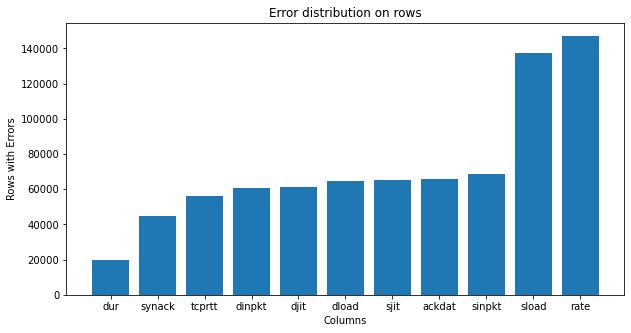

In [23]:
def error_row_column_distribution(all_diffs : List[List], col_positions : List[List]):
    """
    For each row, counts the errors of each column. 
    One or more errors per row for the same column are counted as just +1
    """
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        row_column_errors = []
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            if column in row_column_errors:
                continue
            row_column_errors.append(column)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
sorted_count = error_row_column_distribution(all_diffs, column_bit_position)

bar_plot( sorted_count, x_label="Columns", y_label="Rows with Errors", title="Error distribution on rows")

    	"rate column has 147k rows that are wrong with at least 1 errors in each of the rows"
        "The only columns that have bit errors are: rate, sload, sinpkt, ackdat, sjit,dload,djit,dinpkt,tcprtt,synack, dur"

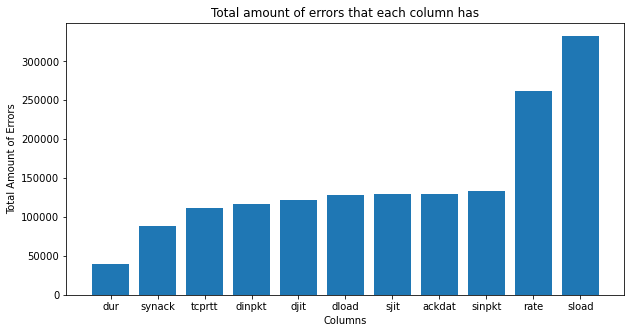

In [24]:
def error_bit_column_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            
            if column not in count_dictionary:
                count_dictionary[column] = 1
            else:
                count_dictionary[column] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    
    return sorted_count

sorted_count = error_bit_column_distribution(all_diffs, column_bit_position)

bar_plot( sorted_count, x_label="Columns", y_label="Total Amount of Errors", title="Total amount of errors that each column has") 

    sload column has a total of 332k errors
    rate column has a total of 261k errors
    sinpkt column has a total of 132k errors

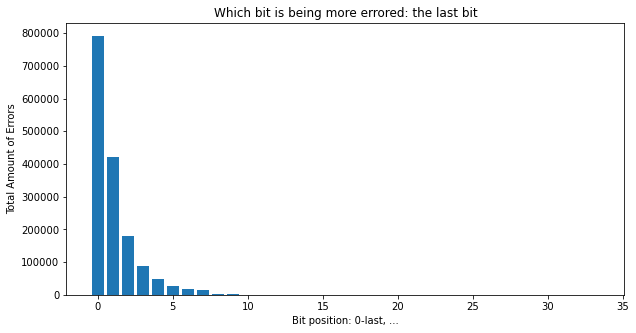

In [25]:
def error_bit_position_distribution(all_diffs : List[List], col_positions : List[List]):
    count_dictionary = {} # key -> bit position starting from last ; value -> count of errors in this position
    for diffs in all_diffs:
        for diff in diffs:
            column, last_pos = belongs_to_column(diff, col_positions)
            position_counting_from_last = last_pos - diff - 1
            
            if position_counting_from_last not in count_dictionary:
                count_dictionary[position_counting_from_last] = 1
            else:
                count_dictionary[position_counting_from_last] += 1
    
    sorted_count = {k:v for k,v in sorted(count_dictionary.items(), key = lambda item: item[1])}
    return sorted_count
sorted_count = error_bit_position_distribution(all_diffs, column_bit_position)
bar_plot( sorted_count, x_label="Bit position: 0-last, ...", y_label="Total Amount of Errors", title="Which bit is being more errored: the last bit") 

    791k of all the errors that are made, are in the last bit
    420k of the errors are on the second to last bit
    179k of the errors are on the third to last bit
    this suggests floating point precision not enough .. ?

# Check the differences between the decimal (not quantized) dataset

#### Get the matlab decimal dataset

In [37]:
decimal_binfeat = pd.read_csv('decimal_binfeat.csv',sep = " ",header=None)
decimal_binfeat = decimal_binfeat.drop(columns = [0,43])
decimal_binfeat.columns = tmp_df.columns.tolist()
print(decimal_binfeat.shape)
decimal_binfeat.head(2)

(257673, 43)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11.0,119,0,5,2,0,496,0,61675100.0,254,0,3.325307e+08,0.0,0,0,11.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,8.0,119,0,5,2,0,1762,0,84803260.0,254,0,1.624272e+09,0.0,0,0,8.0,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0


#### Get the pyhton decimal dataset

In [47]:
print(tmp_df.shape)
tmp_df.head(2)

(257673, 43)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,11.0,119,0,5,2,0,496,0,61675095.11533242464065551757812500,254,0,332530659.277245223522186279296875,0.0,0,0,11.00000000000000177635683940025,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,248,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0
1,8.0,119,0,5,2,0,1762,0,84803256.64857529103755950927734375,254,0,1624271520.675814867019653320312500,0.0,0,0,8.00000000000000000000000000000,0.0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,881,0,0,0,2,2,1,1,1,2,0,0,0,1,2,0,0


## Are they equal? 
    No

In [76]:
decimal_binfeat.equals(tmp_df)

False

## Where are the differences? 
    Floating point precision. Python has more floating point precision than matlab

In [51]:
def highlight_diff(data, color='yellow'):
    attr = 'background-color: {}'.format(color)
    other = data.xs('Pyhton', axis='columns', level=-1)
    return pd.DataFrame(np.where(data.ne(other, level=0), attr, ''),
                        index=data.index, columns=data.columns)

def get_highlight_diff(df1,df2):
    df_all = pd.concat([df1, df2], 
                       axis='columns', keys=['Pyhton', 'Matlab'])
    df_final = df_all.swaplevel(axis='columns')[df1.columns[1:]]
    return df_final.style.apply(highlight_diff, axis=None)

get_highlight_diff(tmp_df.reset_index(drop=True).loc[0:100,:],decimal_binfeat.reset_index(drop=True).loc[0:100,:])